In [ ]:
# Imports 
%run ../header.ipynb
%run ../datascience.ipynb
%run D1A.ipynb
%matplotlib inline

# # NLTK things
# from nltk.util import ngrams

# import bs4
# from bs4 import BeautifulSoup
# print("BeautifulSoup: {}".format(bs4.__version__))

from pyedgar.utilities import (edgarweb, localstore, htmlparse, plaintext, forms)

from psycopg2 import connect as pc

def intornan(val):
    ret = float(val)
    try:
        return int(ret)
    except:
        pass
    return np.nan

# Load the EDGAR filings

Read from /data/storage/edgar/indices/form_10.periods.csv
Missing period: 61,663/748,364 (8.2%)
Missing sic: 14,969/748,364 (2.0%)
Filing delayed >1yr: 5,757/748,364 (0.8%)
Period after 2005: 388,141/748,364 (51.9%)
Num: 748,364	Start: 1986-02-28	End: 2018-03-07


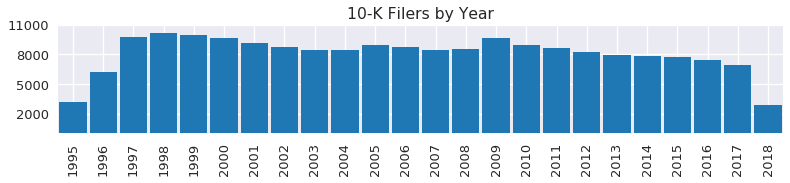

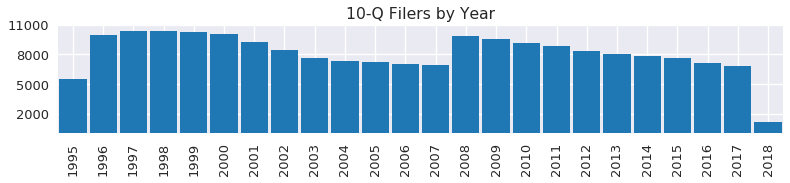

In [2]:
if "Load Filings from EDGAR: df_edgar":
    all_ciks = pd.read_csv(os.path.join(IDX_ROOT, 'all_filings.tab'), sep='\t', usecols=['CIK', ]).CIK.unique()
    df_edgar = pd.concat([pd.read_csv(os.path.join(IDX_ROOT, 'form_10-K.tab'), sep='\t'),
                          pd.read_csv(os.path.join(IDX_ROOT, 'form_10-Q.tab'), sep='\t')])
    df_edgar = (df_edgar[~df_edgar['Form Type'].str.contains('/A')]
                        .sort_values(['CIK', 'Date Filed'])
                        .reset_index(drop=True))
    df_edgar.columns = 'cik name form filedate accession'.split()
    df_edgar['filedate'] = pd.to_datetime(df_edgar.filedate)
    df_edgar['K'] = df_edgar.form.str.contains('K')
    
    # Now add in the periods from previous scrapes
    df_period = pd.read_csv(os.path.join(IDX_ROOT, 'form_10.periods.csv'))
    print("Read from", os.path.join(IDX_ROOT, 'form_10.periods.csv'))
    for c in 'filedate period'.split():
        df_period[c] = pd.to_datetime(df_period[c])

    df_edgar = df_edgar.merge(df_period, on='cik accession'.split(),
                              how='left', suffixes=('', '_period'))
    for c in df_edgar.columns:
        if re.search(r'_period$', c):
            del df_edgar[c]
    
    # Output some stats.
    _tot = _tot_df_edgar = len(df_edgar)
    print("Missing period: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[df_edgar.period.isnull()]), _tot, 
          100.*len(df_edgar[df_edgar.period.isnull()])/_tot))
    print("Missing sic: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[df_edgar.sic.isnull()]), _tot, 
          100.*len(df_edgar[df_edgar.sic.isnull()])/_tot))
    print("Filing delayed >1yr: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[(df_edgar.filedate - df_edgar.period)/TD_DAY > 365]), _tot, 
          100.*len(df_edgar[(df_edgar.filedate - df_edgar.period)/TD_DAY > 365])/_tot))

    _n = len(df_edgar[df_edgar.period > dt.datetime(2005, 1, 1)])
    print("Period after 2005: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))
    print("Num: {:,}\tStart: {:%Y-%m-%d}\tEnd: {:%Y-%m-%d}".format(
          len(df_edgar), df_edgar.period.min(), df_edgar.period.max(), ))
    
    _d = df_edgar['cik filedate form'.split()].copy()
    _d['yr'] = _d.filedate.dt.year
    timehist(_d[_d.form.str.contains('K')].drop_duplicates('cik yr'.split()).filedate)
    plt.title("10-K Filers by Year")
    timehist(_d[_d.form.str.contains('Q')].drop_duplicates('cik yr'.split()).filedate)
    plt.title("10-Q Filers by Year")
    del _d

In [3]:
if not "Add Periods and SICs and save":
    #'period' not in df_edgar or 'sic' not in df_edgar:
    new_sicper = []
    _tmpdf = df_edgar[df_edgar.period.isnull() | df_edgar.sic.isnull()]
    for i,row in tqdm(_tmpdf.iterrows(), total=len(_tmpdf)):
        doperiod = pd.isnull(row.period)
        dosic = pd.isnull(row.sic)
        if not doperiod and not dosic:
            continue

        p = localstore.get_filing_path(row.cik, row.accession)
        sic, period = None, None

        try:
            with open(p) as fh:
                txt = fh.read(5000).strip()
        except FileNotFoundError:
            continue
        if not txt:
            continue

        if doperiod:
            period = forms.get_header(txt, 'PERIOD')
    #         print(i,period)
            if period and len(period) == 8:
                period = dt.date(int(period[:4]), 
                                 int(period[4:6]),
                                 int(period[-2:]))
        if dosic:
            sic = forms.get_header(txt, 'ASSIGNED-SIC')
            if sic and (1 <= len(sic) <= 4):
                try:
                    sic = int(sic)
                except:
                    pass

        if period or sic:
            new_sicper.append({'cik':row.cik, 'accession':row.accession,
                               'sic':sic, 'period':period})
    
    # Now add these new SICs to the dataframe
    if new_sicper:
        tmpdf = pd.DataFrame(new_sicper)
        if 'sic' in tmpdf:
            tmpdf['sic'] = tmpdf['sic'].apply(lambda x: float(x) if x else None)
            df_edgar['sic'] = df_edgar['sic'].astype(float)
        if 'period' in tmpdf:
            tmpdf['period'] = pd.to_datetime(tmpdf['period'])
        print("Adding {} rows to df_edgar".format(len(new_sicper)))

        print("Before: ", len(df_edgar[df_edgar.sic.isnull()]),'/',len(df_edgar),
              100*len(df_edgar[df_edgar.sic.isnull()])/len(df_edgar))
        df_edgar = df_edgar.merge(tmpdf, on='cik accession'.split(), 
                                  how='left', suffixes=('', '_new'))

        for c in 'sic period'.split():
            df_edgar[c] = df_edgar[c].fillna(df_edgar[c+'_new'])
            del df_edgar[c+'_new']

        print("After: ", len(df_edgar[df_edgar.sic.isnull()]),'/',len(df_edgar),
              100*len(df_edgar[df_edgar.sic.isnull()])/len(df_edgar))

        df_edgar.sort_values('cik filedate'.split(), inplace=True)

        for ffnum in [12, 48]:
            df_ff = get_ffind_df(ffnum)
            del df_ff['detail']
            df_edgar = df_edgar.merge(df_ff, on='sic', how='left', suffixes=('', '_new'))

            for c in df_ff.columns:
                if c == 'sic': continue
                df_edgar[c] = df_edgar[c].fillna(df_edgar[c+'_new'])
                del df_edgar[c+'_new']

        _fnam = 'form_10.periods.{:%Y%m%d}.csv'.format(dt.date.today())
        df_edgar.to_csv(os.path.join(IDX_ROOT, _fnam), index=False)

    df_edgar['sic'] = df_edgar.groupby('cik').sic.ffill()
    df_edgar['sic'] = df_edgar.groupby('cik').sic.bfill()

In [4]:
if not "Overwrite main periods file":
    assert os.path.exists(os.path.join(IDX_ROOT, _fnam))
    _fnam_master = 'form_10.periods.csv'
    import shutil
    shutil.copy2(os.path.join(IDX_ROOT, _fnam), os.path.join(IDX_ROOT, _fnam_master))

# Load the compustat fundamentals

In [5]:
# Fill missing begin/end dates for between matches
MIN_DATE = dt.date(1901, 1, 1)
MAX_DATE = dt.date(2050, 1, 1)

In [6]:
# Load password file for wrds
# I made this by typing my WRDS password into a text file at path below.
# Pretty simple. Pretty insecure.
pwd_file = os.path.expanduser('~/Dropbox/Documents/Personal/config/wrds.pwd')
with open(pwd_file, 'r', encoding='utf-8') as fh:
    wrds_password = fh.read().strip()

In [ ]:
if "GVKEY-CIK link: df_hist":
    try:
        conn = pc(dbname="wrds", 
                  user="gaulinmp",
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  password=wrds_password.strip(),
                  sslmode='require')
    
        df_hist = pd.read_sql('SELECT gvkey '
                              ',  hcik AS cik '
                              ',  hipodate AS ipo_date '
                              ',  hdldte AS crsp_valid_date '
                              ',  hchgdt AS link_start '
                              ',  hchgenddt AS link_end '
                              ',  hfyrc AS fyr '
                              ',  hsic AS sic '
                              ',  hggroup as gics_group '
                              ',  hgind as gics_ind '
                              ',  hgsector as gics_sector '
                              ',  hgsubind as gics_subind '
                              'FROM crsp.comphist '
                              'ORDER BY gvkey, link_start;',
                              conn,
                              parse_dates='ipo_date crsp_valid_date link_start link_end'.split())
    finally:
        conn.close()

    df_hist.loc[df_hist.link_start.isnull(), 'link_start'] = MIN_DATE
    df_hist.loc[df_hist.link_end.isnull(), 'link_end'] = MAX_DATE
    
    for c in 'cik sic gics_group gics_ind gics_sector gics_subind'.split():
        df_hist[c] = df_hist.groupby('gvkey')[c].ffill()
        df_hist[c] = df_hist.groupby('gvkey')[c].bfill()
        df_hist[c] = df_hist[c].apply(intornan)
    
    df_hist['gvkey'] = df_hist['gvkey'].apply(intornan)
    
    df_hist = df_hist[df_hist['cik gics_group gics_ind gics_sector gics_subind'.split()]
                             .notnull().any(axis=1)]

In [7]:
if not "Write out GVKEY-CIK link file":
    df_hist.to_stata(os.path.join(SHARED_DATA_ROOT, 'gvkey_cik_link.dta'), write_index=False)

In [8]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in COMPHIST: {len(df_hist[df_hist.cik.notnull()].cik.unique()):,d}')

_d = df_hist[df_hist.cik.notnull() & ~df_hist.cik.isin(all_ciks)]
print(f'Number CIKs in COMPHIST, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_hist):4.2f}% link obs)')

_d = df_hist[df_hist.cik.notnull() & ~df_hist.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in COMPHIST, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_hist):4.2f}% link obs)')

Number unique CIKs in EDGAR: 627,986
Number unique CIKs in EDGAR (with at least one 10-K/Q): 38,277
Number unique CIKs in COMPHIST: 33,045
Number CIKs in COMPHIST, not in EDGAR: 5,610 (6.04% link obs)
Number CIKs in COMPHIST, not in EDGAR (w/ 10-K/Q): 14,332 (29.52% link obs)


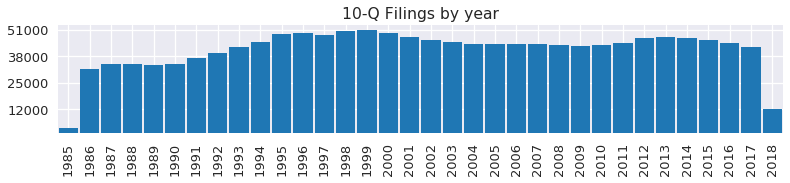

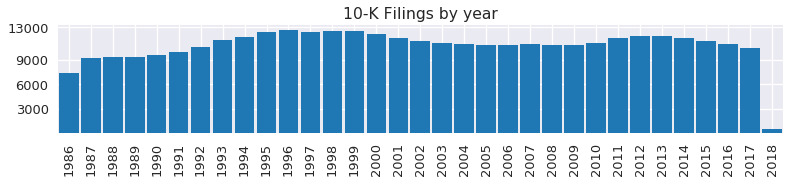

In [9]:
if "Load Compustat from WRDS postgres server: df_compq/df_compa":
    try:
        conn = pc(dbname="wrds", 
                  user="gaulinmp",
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  password=wrds_password.strip(),
                  sslmode='require')
        
        df_fundq = pd.read_sql("SELECT a.gvkey, a.datadate, a.fyearq, a.rdq, "
                               "a.fyr, a.fqtr, a.datafqtr, a.datacqtr, b.fundq_start, "
                               "a.tic, a.cusip, a.conm, a.atq, a.niq, "
                               "a.prccq * a.cshoq  AS mcapq "
                               "FROM comp.fundq a "
                               "LEFT JOIN (SELECT gvkey, MIN(datadate) AS fundq_start "
                               "           FROM comp.fundq GROUP BY gvkey) b "
                               "    ON (a.gvkey = b.gvkey) "
                               "WHERE a.INDFMT = 'INDL' "
                               "    AND a.DATAFMT = 'STD' "
                               "    AND a.POPSRC = 'D' "
                               "    AND a.CONSOL = 'C' "
                               "    AND a.fyearq > 1985 "
                               "ORDER BY a.gvkey, a.datafqtr, a.datacqtr;",
                               conn,
                               parse_dates='datadate rdq fundq_start'.split())
        timehist(df_fundq.datadate)
        plt.title("10-Q Filings by year")
        
        df_funda = pd.read_sql("SELECT a.gvkey, a.datadate, a.fyear, "
                               "a.fyr, a.sich, a.cik, b.funda_start, "
                               "a.tic, a.cusip, a.conm, a.fic, a.at, a.ni, "
                               "a.prcc_f * a.csho  AS mcap "
                               "FROM comp.funda a "
                               "LEFT JOIN (SELECT gvkey, MIN(datadate) AS funda_start "
                               "           FROM comp.funda GROUP BY gvkey) b "
                               "    ON (a.gvkey = b.gvkey) "
                               "WHERE a.INDFMT = 'INDL' "
                               "    AND a.DATAFMT = 'STD' "
                               "    AND a.POPSRC = 'D' "
                               "    AND a.CONSOL = 'C' "
                               "    AND a.fyear > 1985 "
                               "ORDER BY a.gvkey, a.fyear, a.fyr;",
                               conn,
                               parse_dates='datadate funda_start'.split())
        timehist(df_funda.datadate)
        plt.title("10-K Filings by year")
    finally:
        conn.close()

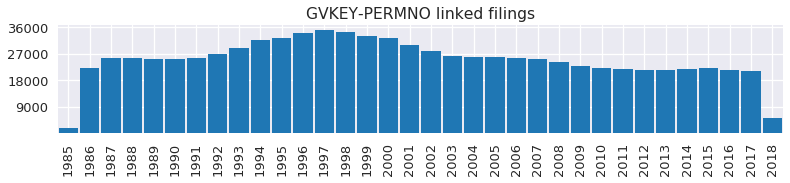

In [10]:
if "GVKEY-PERMNO link: df_crsp":
    try:
        conn = pc(dbname="wrds", 
                  user="gaulinmp",
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  password=wrds_password.strip(),
                  sslmode='require')
    
        df_ccm = pd.read_sql('SELECT * '
                             'FROM crsp.ccmxpf_linktable;'
                             , conn, parse_dates='linkdt linkenddt'.split())
    finally:
        conn.close()

    df_ccm = df_ccm[df_ccm.linktype.str.contains(r'L[UC]', regex=True)]
    df_ccm['linkdt'] = df_ccm['linkdt'].fillna(MIN_DATE)
    df_ccm['linkenddt'] = df_ccm['linkenddt'].fillna(MAX_DATE)
    
    _d = (pd.merge(pd.concat([df_funda['gvkey datadate'.split()],
                              df_fundq['gvkey datadate'.split()]], sort=False).drop_duplicates(),
                   df_ccm['gvkey linkprim liid lpermno lpermco linkdt linkenddt'.split()],
                   on='gvkey', how='inner')
            .sort_values('gvkey datadate linkdt linkprim'.split()))

    _d = (_d[_d.datadate.between(_d.linkdt, _d.linkenddt)]
            .sort_values('gvkey datadate linkprim'.split(), ascending=False)
            .reset_index(drop=True) # reset the index to be 1-N
            .reset_index()) # Add that 1-N to the dataframe
    # Now subtract the gvkey-datadate min, resulting in numbered permnos by linkprim
    _d['index'] -= _d.groupby('gvkey datadate'.split())['index'].transform(min) - 1

    # Now pivot those gvkey-datadate rows into columns with numbered permnos
    df_crsp = (_d.pivot_table(index='gvkey datadate'.split(),
                              columns='index',
                              values='lpermco lpermno'.split())
                 .reset_index()) # Reset index moves gvkey-datadate into the dataframe
    
    df_crsp.columns = [f"{a.replace('lperm', 'perm')}{str(b).replace('1', '')}"
                       for a,b in df_crsp.columns.get_values()]
    
    df_crsp['gvkey'] = df_crsp.gvkey.astype(int)
    timehist(df_crsp[df_crsp.permno.notnull()].datadate)
    _ = plt.title('GVKEY-PERMNO linked filings')

Matched 96,404 firm-years to comphist
Kept 87,013 CIK firm-years from comphist
Kept 198,337 CIK firm-years from comphist after filling
Kept 306,002 CIK firm-years after combination


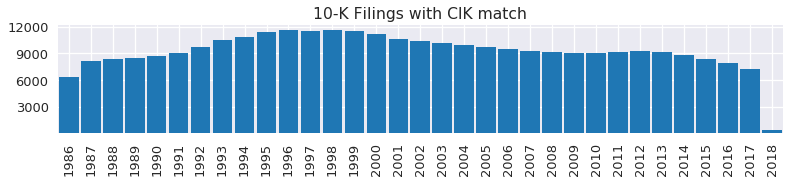

In [11]:
if "Clean Compustat tables: df_compa":
    _uniquekeys = 'gvkey fyear fyr datadate'.split()
    
    df_compa = (pd.merge(df_funda,
                         df_fundq.loc[df_fundq.fyearq.notnull() & df_fundq.fyr.notnull(),
                                      'gvkey fyearq fyr datadate fqtr datafqtr '
                                      'datacqtr rdq fundq_start'.split()],
                         left_on='gvkey fyear fyr datadate'.split(),
                         right_on='gvkey fyearq fyr datadate'.split(),
                         how='left', 
                         suffixes=('', '_errorize'))
                  .sort_values('gvkey fyear fyr'.split()))
    
    assert(all(['_errorize' not in c for c in df_compa.columns]))
    
    for c in 'gvkey fyear fyr sich cik'.split():
        df_compa[c] = df_compa[c].astype(float).apply(intornan)

    _prelen = len(df_compa)
    _predups = len(df_compa[df_compa.duplicated(_uniquekeys)])
    assert(0 == _predups)

    _compa = pd.merge(df_compa, df_hist, on='gvkey', how='inner', suffixes=('', '_comphist'))
    _compa = _compa[_compa.datadate.between(_compa.link_start, _compa.link_end)]
    # Rename sic to sic_comphist
    _compa.columns = [c if c != 'sic' else 'sic_comphist' for c in _compa.columns]
    print(f"Matched {len(_compa):,d} firm-years to comphist")
    
    assert(_predups == len(_compa[_compa.duplicated(_uniquekeys)]))

    _compa = (pd.concat([_compa, df_compa], sort=False)
                .sort_values(_uniquekeys + ['cik_comphist', ])
                .drop_duplicates(_uniquekeys)
                .sort_values(_uniquekeys)
                .reset_index(drop=True))
    print(f"Kept {len(_compa[_compa.cik_comphist.notnull()]):,d} CIK firm-years from comphist")

    # don't do .bfill() here, that breaks on groupby apparently.
    # Doesn't sort properly.
    for c in 'gics_group gics_ind gics_sector gics_subind cusip'.split():
        _compa[c] = _compa.groupby('gvkey')[c].fillna(method='ffill')
        _compa[c] = _compa.groupby('gvkey')[c].fillna(method='bfill')

    _compa['cik_comphist'] = _compa.groupby('gvkey').cik_comphist.fillna(method='bfill')
    # _compa['cik_comphist'] = _compa.groupby('gvkey').cik_comphist.fillna(method='ffill')
    print(f"Kept {len(_compa[_compa.cik_comphist.notnull()]):,d} CIK firm-years from comphist after filling")

    assert(_prelen == len(_compa))
    
    df_compa = _compa.merge(df_crsp, how='left')
    assert(_prelen == len(df_compa))
    
    del _compa
    for c in 'fyr_comphist crsp_valid_date link_start link_end fyearq'.split():
        del df_compa[c]

    df_compa['cik_funda'] = df_compa['cik']
    df_compa['cik'] = df_compa.cik_comphist.fillna(df_compa.cik_funda)
    print(f"Kept {len(df_compa[df_compa.cik.notnull()]):,d} CIK firm-years after combination")
    
    timehist(df_compa[df_compa.cik.notnull()].datadate)
    _ = plt.title('10-K Filings with CIK match')

In [12]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in FUNDA: {len(df_compa[df_compa.cik.notnull()].cik.unique()):,d}')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(all_ciks)]
print(f'Number CIKs in FUNDA, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique()) & (df_compa['at']>0)]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +Assets): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique()) & df_compa.permno.notnull()]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +PERMNO): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

Number unique CIKs in EDGAR: 627,986
Number unique CIKs in EDGAR (with at least one 10-K/Q): 38,277
Number unique CIKs in FUNDA: 26,470
Number CIKs in FUNDA, not in EDGAR: 2,961 (3.84% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q): 9,490 (22.14% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +Assets): 8,305 (16.34% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +PERMNO): 6,227 (12.62% firm-years)


Matched 389,043 firm-years to comphist
Kept 351,265 CIK firm-years from comphist
Kept 818,953 CIK firm-years from comphist after filling
Kept 1,191,736 CIK firm-years after combination


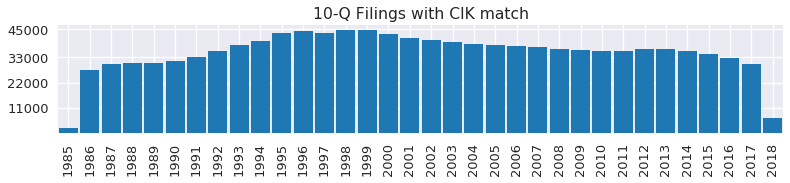

In [13]:
if "Clean Compustat tables: df_compq":
    _uniquekeys = 'gvkey fyearq fyr fqtr'.split()
    
    df_compq = (pd.merge(df_fundq,
                         df_funda.loc[df_funda.fyear.notnull() & df_funda.fyr.notnull(),
                                      'gvkey fyear fyr funda_start sich cik'.split()],
                         left_on='gvkey fyearq fyr'.split(),
                         right_on='gvkey fyear fyr'.split(),
                         how='left', 
                         suffixes=('', '_errorize'))
                  .query("gvkey != '020966'") # Canadian company that FUNDQ duplicates
                  .sort_values('gvkey fyearq fyr fqtr'.split()))
    
    assert(all(['_errorize' not in c for c in df_compq.columns]))
    
    for c in 'gvkey fyearq fyr fqtr sich cik'.split():
        df_compq[c] = df_compq[c].astype(float).apply(intornan)

    _prelen = len(df_compq)
    assert(0 == len(df_compq[df_compq.duplicated(_uniquekeys)]))

    _compq = pd.merge(df_compq, df_hist, on='gvkey', how='inner', suffixes=('', '_comphist'))
    _compq = _compq[_compq.datadate.between(_compq.link_start, _compq.link_end)]
    # Rename sic to sic_comphist
    _compq.columns = [c if c != 'sic' else 'sic_comphist' for c in _compq.columns]
    print(f"Matched {len(_compq):,d} firm-years to comphist")
    
    # We didn't add any duplicates did we?
    assert(0 == len(_compq[_compq.duplicated(_uniquekeys)]))

    _compq = (pd.concat([_compq, df_compq], sort=False)
                .sort_values(_uniquekeys + ['cik_comphist', ])
                .drop_duplicates(_uniquekeys)
                .sort_values(_uniquekeys)
                .reset_index(drop=True))
    print(f"Kept {len(_compq[_compq.cik_comphist.notnull()]):,d} CIK firm-years from comphist")

    # don't do .bfill() here, that breaks on groupby apparently.
    # Doesn't sort properly.
    for c in 'gics_group gics_ind gics_sector gics_subind cusip'.split():
        _compq[c] = _compq.groupby('gvkey')[c].fillna(method='ffill')
        _compq[c] = _compq.groupby('gvkey')[c].fillna(method='bfill')

    _compq['cik_comphist'] = _compq.groupby('gvkey').cik_comphist.fillna(method='bfill')
    # _compq['cik_comphist'] = _compq.groupby('gvkey').cik_comphist.fillna(method='ffill')
    print(f"Kept {len(_compq[_compq.cik_comphist.notnull()]):,d} CIK firm-years from comphist after filling")

    assert(_prelen == len(_compq))

    df_compq = _compq.merge(df_crsp, how='left')
    assert(_prelen == len(df_compq))
    
    del _compq
    for c in 'fyr_comphist crsp_valid_date link_start link_end fyear'.split():
        del df_compq[c]

    df_compq['cik_funda'] = df_compq['cik']
    df_compq['cik'] = df_compq.cik_comphist.fillna(df_compq.cik_funda)
    
    timehist(df_compq[df_compq.cik.notnull()].datadate)
    plt.title('10-Q Filings with CIK match')
    
    print(f"Kept {len(df_compq[df_compq.cik.notnull()]):,d} CIK firm-years after combination")

In [14]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in FUNDQ: {len(df_compq[df_compq.cik.notnull()].cik.unique()):,d}')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(all_ciks)]
print(f'Number CIKs in FUNDQ, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique()) & (df_compq.atq>0)]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +Assets): '      
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique()) & df_compq.permno.notnull()]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +PERMNO): '      
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

Number unique CIKs in EDGAR: 627,986
Number unique CIKs in EDGAR (with at least one 10-K/Q): 38,277
Number unique CIKs in FUNDQ: 26,567
Number CIKs in FUNDQ, not in EDGAR: 2,961 (3.54% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q): 9,543 (21.57% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +Assets): 8,371 (13.76% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +PERMNO): 6,321 (12.52% firm-years)


In [15]:
if not "Write fundq.csv out":
    _sel = (df_compq.groupby('gvkey').cik.max() > 0).reset_index()
    _sel = df_compq.gvkey.isin(_sel[_sel.cik].gvkey.unique())
    _sel &= df_compq.fyearq > 1990

    print("Writing {} lines  to: {}".format(len(df_compq[_sel]),
          os.path.join(SHARED_DATA_ROOT, 'fundq.csv')))
    df_compq[_sel].to_csv(os.path.join(SHARED_DATA_ROOT, 'fundq.csv'), index=False)
    
if not "Write funda.csv out":
    _sel = (df_compa.groupby('gvkey').cik.max() > 0).reset_index()
    _sel = df_compa.gvkey.isin(_sel[_sel.cik].gvkey.unique())
    _sel &= df_compa.fyear > 1990
    
    _fpath = os.path.join(SHARED_DATA_ROOT, 'funda_all.csv')

    print("Writing {} lines  to: {}".format(len(df_compa[_sel]), _fpath))
    df_compa[_sel].to_csv(_fpath, index=False)

In [16]:
if not "Emergency clean PostgreSQL connection":
    # If you use with pc() as conn:, it doesn't close the connection
    # Learned this the hard way :(
    # So then I got to learn about too many open connection errors
    # This is the fix for that problem, thanks to:
    # https://stackoverflow.com/a/25067055/1959876
    try:
        conn = pc(dbname="wrds", 
                  user="gaulinmp",
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  password=wrds_password.strip(),
                  sslmode='require')
        
        # Change this to pg_cancel_backend(pid) for more peaceful termination
        df_kill = pd.read_sql("""SELECT pg_terminate_backend(pid)
                                FROM   pg_stat_activity
                                WHERE  usename = 'gaulinmp'
                                AND    pid <> pg_backend_pid();""", conn)
    
    finally:
        conn.close()

# Now merge in EDGAR filings

In [220]:
if "Combine Compustat EDGAR: df_all":
    _uniquekeys = 'gvkey datadate fyearq fyr fqtr rdq cik'.split()
    _groupkeys = 'gvkey datadate fyearq fyr fqtr cik'.split()
    _groupkeys_nocik = [c for c in _groupkeys if c != 'cik']
    
    # Stack compustat DF so both ciks (funda and comphist) are searched for.
    _add_ciks = 'cik_comphist cik_funda'.split()
    df_comp_in = df_compq.loc[df_compq.cik.notnull(), _uniquekeys + _add_ciks]
    df_comp_in['cik_order'] = 1
    for i,c in enumerate(_add_ciks):
        _extra = df_comp_in[(df_comp_in.cik != df_comp_in[c]) & df_comp_in[c].notnull()].copy()
        if len(_extra) == 0:
            continue
        _extra['cik'] = _extra[c]
        _extra['cik_order'] = i+1
        print("Adding from ", c, len(_extra))
        df_comp_in = pd.concat([df_comp_in, _extra]).sort_values(_uniquekeys)
    
    print(f"Step 0: {len(df_comp_in.loc[df_comp_in.cik.notnull(), _uniquekeys])} "
          f"({len(df_comp_in[df_comp_in.cik.notnull() & df_comp_in.duplicated(_uniquekeys, keep=False)])} dups)")
    df_all = pd.merge(df_comp_in[_uniquekeys + ['cik_order', ]],
                      df_edgar['cik accession filedate period K'.split()], 
                      how='inner', on='cik')

    print(f"Step 1: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    # Step 1: 10-Ks are Q4, Qs are not. (this is XOR!)
    df_all = df_all[df_all.K ^ (df_all.fqtr != 4)]

    print(f"Step 2: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    # Step 2: Choose closest period-datadate and rdq-filedate match.
    df_all['d-p'] = ((df_all['datadate'] - df_all['period'])/TD_DAY).abs()
    df_all['r-f'] = ((df_all['rdq'] - df_all['filedate'])/TD_DAY).abs()

    df_all['mindp'] = (df_all['d-p']==df_all.groupby(_groupkeys)['d-p'].transform(min))
    df_all['minrf'] = (df_all['r-f']==df_all.groupby(_groupkeys)['r-f'].transform(min))

    df_all['minboth'] = df_all['mindp'] & df_all['minrf']

    sel = (df_all['d-p'] < 30) | (df_all['r-f'] < 30)
    sel &= (df_all.mindp|df_all.minrf)
    sel &= (df_all.mindp & df_all.minrf) | (~df_all.groupby(_groupkeys)['minboth'].transform(max).astype(bool))
    df_all = df_all[sel]
    
    print(f"Step 3: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    # Step 3: Keep matches with 1 accession, or those with filedate on or after RDQ
    df_all['acc_num'] = df_all.groupby(_groupkeys)['accession'].transform('count')
    df_all = df_all[(df_all.acc_num == 1) |
                    ((df_all.acc_num > 1) & (df_all.filedate >= df_all.rdq.fillna(df_all.filedate)))]
    del df_all['acc_num']
    
    print(f"Step 4: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    # Step 4: Sum d-p and r-f date-delays, and keep the smallest under 2 months
    df_all['diffsum'] = df_all['d-p'].fillna(0) + df_all['r-f'].fillna(0)
    df_all = (df_all[df_all.diffsum <= 60]
                    .sort_values(_groupkeys + ['diffsum', ])
                    .drop_duplicates(_groupkeys))
    
    print(f"Step 5: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys_nocik))} no-cik dups)")
    # Step 5: Handle comphist CIK duplicates.
    #         Keep comphist first (cik_order==1), then funda (cik_order==2)
    df_all = df_all.sort_values(_groupkeys_nocik + ['cik_order',]).drop_duplicates(_groupkeys_nocik)
    del df_all['cik_order']
    
    print(f"Step 6: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    # Step 6: Add back other compq data, keeping CIK we used
    df_all['cik_used'] = df_all['cik']
    del df_all['cik']
    df_all = df_all.merge(df_compq, how='left', suffixes=('', '_delete'))
    df_all['cik'] = df_all['cik_used']

    for c in df_all.columns:
        if '_delete' in c:
            del df_all[c]
            
    print(f"Step 7: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")

    df_all = df_all.merge(df_edgar, on='cik accession'.split(), 
                          how='left', suffixes=('', '_delete'))
    for c in df_all.columns:
        if '_delete' in c:
            del df_all[c]

    for c in 'cik_used mindp minrf minboth diffsum'.split():
        if c not in df_all:
            continue
        del df_all[c]
    
    df_all = (df_all.sort_values(_uniquekeys)
                    .rename(mapper=str, 
                            columns={'conm': 'comp_name', 'name': 'edgar_name',
                                     'sich': 'sic_comp', 'sic': 'sic_edgar'}))
    
    print(f"Step 8: {len(df_all)} "
          f"({sum(df_all.duplicated(_groupkeys))} dups)")
    
    df_all.to_csv(os.path.join(SHARED_DATA_ROOT, 'edgar_fundq_join.tab'), sep='\t', index=False)

    timehist(df_all.datadate)

Adding from  cik_funda 27583
Step 0: 1219319 (0 dups)
Step 1: 43771281 (42865405 dups)
Step 2: 27455941 (26559877 dups)
Step 3: 528821 (428 dups)
Step 4: 528672 (283 dups)
Step 5: 519387 (882 no-cik dups)
Step 6: 518505 (0 dups)
Step 7: 518505 (0 dups)
Step 8: 518505 (0 dups)


In [226]:
# Print stats
print("2016-05-01: Compustat(14,199) ( 3,783 (10,416) 25,149 ) (35,565)EDGAR")
print("2016-07-14: Compustat(14,285) ( 4,175 (10,110) 11,842 ) (21,952)EDGAR")
print("2016-07-22: Compustat(14,285) ( 3,825 (10,460) 27,026 ) (37,486)EDGAR")
print("2016-08-04: Compustat(21,418) ( 5,501 (15,917) 21,569 ) (37,486)EDGAR")
print("2018-07-06: Compustat(26,568) ( 9,544 (17,024) 21,253 ) (38,277)EDGAR",'\n')
print('{:%Y-%m-%d}: Compustat({:,d}) ( {:,d} ({:,d}) {:,d} ) ({:,d})EDGAR'
      .format(dt.date.today(),
     len(df_compq.cik.unique()),
     len(set(df_compq.cik.unique()) - set(df_edgar.cik.unique())),
     len(set(df_edgar.cik.unique()) & set(df_compq.cik.unique())),
     len(set(df_edgar.cik.unique()) - set(df_compq.cik.unique())), 
     len(df_edgar.cik.unique()),
))

2016-05-01: Compustat(14,199) ( 3,783 (10,416) 25,149 ) (35,565)EDGAR
2016-07-14: Compustat(14,285) ( 4,175 (10,110) 11,842 ) (21,952)EDGAR
2016-07-22: Compustat(14,285) ( 3,825 (10,460) 27,026 ) (37,486)EDGAR
2016-08-04: Compustat(21,418) ( 5,501 (15,917) 21,569 ) (37,486)EDGAR 

2018-07-06: Compustat(26,568) ( 9,544 (17,024) 21,253 ) (38,277)EDGAR


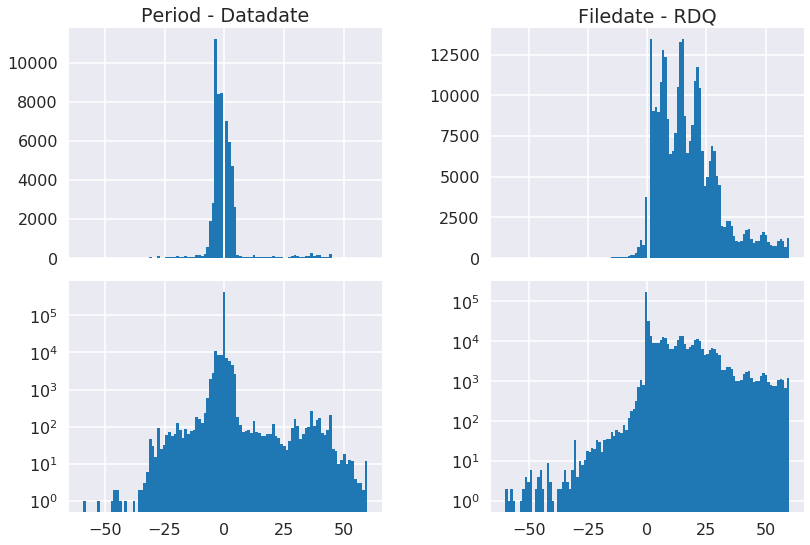

In [239]:
# Plot the date-matches
sns.set_context('poster')
plt.figure(figsize=(12, 8))
d = (df_all[df_all.period.notnull()].period - df_all[df_all.period.notnull()].datadate) / TD_DAY
plt.subplot(221)
d[d != 0].hist(bins=len(d.unique()))
plt.title("Period - Datadate")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(223)
d.hist(bins=len(d.unique()))
plt.yscale('log')

d = (df_all[df_all.rdq.notnull()].filedate - df_all[df_all.rdq.notnull()].rdq) / TD_DAY
plt.subplot(222)
d[~d.isin((0,1))].hist(bins=len(d.unique()))
plt.title("Filedate - RDQ")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(224)
d.hist(bins=len(d.unique()))
plt.yscale('log')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95,
                    hspace=0.1, wspace=0.35)

plt.show()

# Stats for EDGAR -- Final sample decrease

In [35]:
if "Combine Compustat EDGAR: df_all":
    df_sall = pd.merge(df_edgar, df_compq, how='left', on='cik')

    _tot = _tot_df_edgar
    _n = len(df_sall[df_sall.datafqtr.isnull()])
    print("No Comp CIK match: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))
    
    df_sall = df_sall[df_sall.datafqtr.notnull()]
    
    df_sall = df_sall[(df_sall.datadate > df_sall.period - 5 * TD_DAY) & 
                      (df_sall.datadate < df_sall.period + 6 * TD_DAY)]
    df_sall.sort_values('cik datafqtr filedate'.split(), inplace=True)
    
    sel  = df_sall.form.str.contains('K') & (df_sall.fqtr == 4)
    sel |= df_sall.form.str.contains('Q') & (df_sall.fqtr != 4)

    df_sall = df_sall[sel].drop_duplicates('gvkey datafqtr'.split())
    
    _n = len(df_sall)
    print("Matches Compustat dates: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))
    
    _n = len(df_sall[df_sall.atq.isnull()])
    print("No AT: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))
    
    _n = len(df_sall[df_sall.atq < 1])
    print("AT < 1: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))

No Comp CIK match: 264,696/702,731 (37.7%)
Matches Compustat dates: 235,319/702,731 (33.5%)
No AT: 1,246/702,731 (0.2%)
AT < 1: 10,475/702,731 (1.5%)
